## Import libraries

In [1]:
import time

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = [12,6]
sns.set_style('whitegrid')

## Import dataset

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* Our data consist of 31 columns.
* All are numerical variables.
* There is no missing values.
* Our dependent variable is 'Class' and the rest are independent variables.

Let's just the 'Time' columns since we cannot do anything with it.

In [5]:
df.drop('Time',axis=1,inplace=True)

Almost all variables are unknown and it is hard to do analysis because we do not know what each column represents to. So, I'll just skip the exploratory data analysis part.

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

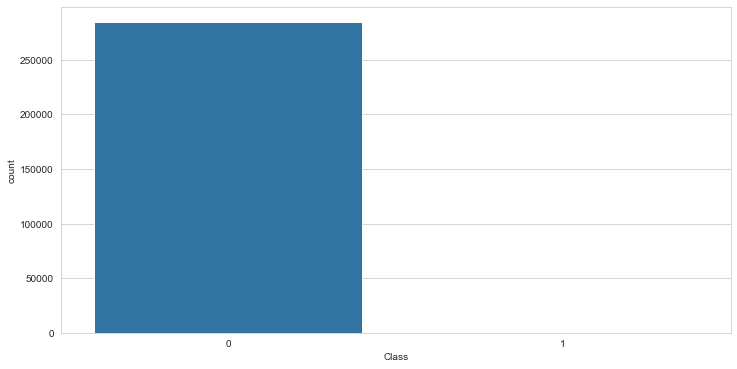

In [7]:
sns.countplot(x=df['Class'])

Here, we can clearly see that this is an imbalanced dataset. We have like 0.0017% fraud transactions.

# Set the evaluation metric
Our objective is to detect all fraud transactions (true positive). we need to make sure that no fraud transactions are being classified as non-fraud (false negative) and no non-fraud transactions are being classified as fraud (false positive). So, we need to keep this false negative and false positive as low as possible.

$$
Recall = \frac{True Positive}{True Positive + False Negative}
$$

High recall score indicates low false negative.

$$
Precision = \frac{True Positive}{True Positive + False Positive}
$$

High precision score indicates low false positive.

$$
F1 = 2 \frac {Precision * Recall}{Precision + Recall}
$$

We can also use F1-score, a metric that conveys both precision score and recall score.

# Splitting the dataset into training set and test set

In [8]:
X = df.drop("Class",axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scaling/Normalization
Next, we will do scaling on our data because we will be using distance-based algorithm.

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building machine learning model

In [10]:
lr = LogisticRegression(max_iter=5000)
knn = KNeighborsClassifier()
svm = SVC()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
lgbm = LGBMClassifier(is_unbalanced=True)

In [11]:
models = [(lr,'Logistic Regression'), (knn,'K-Nearest Neighbors'), (svm,'Support Vector Classifier'),
          (tree,'Decision Tree Classifier'), (forest,'Random Forest Classifier'),
         (lgbm,'LightGBM Classifier')]

In [12]:
scores = []
model_name = []
training_time = []

for model in models:
    
    start = time.time()
    
    # training
    model[0].fit(X_train_scaled,y_train)
    
    # prediction
    prediction = model[0].predict(X_test_scaled)
    
    # evaluation
    score = f1_score(y_test,prediction)
    scores.append(score)
    
    end = time.time()
    
    # computational time
    difference = end - start
    training_time.append(difference)
    
    # model_name
    model_name.append(model[1])

data = []
for x in (zip(scores,training_time)):
    data.append(x)
    
model_df = pd.DataFrame(data,index=model_name,columns=['F1-score','Computational Time (seconds)'])
model_df

,F1-score,Computational Time (seconds)
Logistic Regression,0.709924,2.062899
K-Nearest Neighbors,0.819788,686.037193
Support Vector Classifier,0.759690,338.932644
Decision Tree Classifier,0.760000,12.093573
Random Forest Classifier,0.845070,180.245673
LightGBM Classifier,0.333333,3.141009


* Random Forest scores the best followed by K-Nearest Neighbors.
* But look at their computational time. Random Forest performed 74% faster compare to K-Nearest Neighbors.
* LightGBM performed the worst, but maybe we can improve this model by tuning the hyperparameters.
* We'll choose LightGBM for the hyperparameter tuning part. Less computational time means it is easier for us to find the optimal hyperparameters.

# Hyperparameter tuning

In [46]:
param = {}
param['n_estimators'] = [1000,1500]
param['max_depth'] = [10,15]
param['learning_rate'] = [0.01,0.1]
param['objective'] = ['binary']
param['reg_lambda'] = [1,2]
param['reg_alpha'] = [1,2]
param['n_jobs'] = [-1]
param['colsample_bytree'] = [0.2,0.5]

grid = GridSearchCV(lgbm, param, n_jobs=-1, scoring='f1')
grid.fit(X_train_scaled, y_train)
grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1500,
 'n_jobs': -1,
 'objective': 'binary',
 'reg_alpha': 1,
 'reg_lambda': 1}

In [47]:
prediction = grid.predict(X_test_scaled)
score = f1_score(y_test,prediction)
score

0.8421052631578948

Looks like we manage to increase the F1-score from 33.3% to 84.2%. That is such a huge improvement.